## This notebook generates the components of Extended Data Figure 3 

in "Entrained debris records regrowth of the Greenland Ice Sheet after the last interglacial" 

---
That figure contains the following components

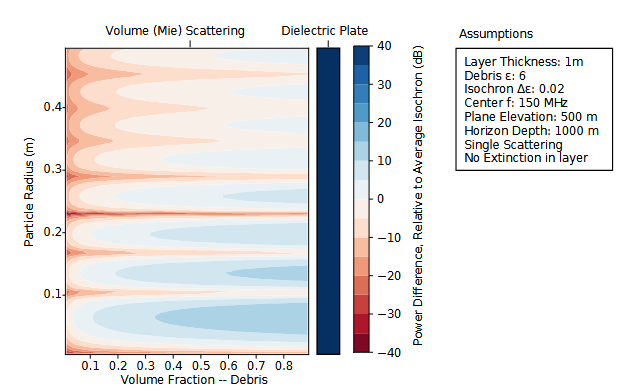

In [9]:
#############################################
### Necessary input statements

######## System untilities
import sys

######## Numerical and plotting tools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
from scipy import signal

######## Any necessary path additions can go here:
sys.path.append('/mnt/data01/Code/opr_python/')

######## miepython library --  https://miepython.readthedocs.io/en/latest/01_basics.html
import miepython

generate_pdfs_flag = 0

In [10]:
def _pos_imag_sqrt(z):
    """
    Square root with the physically common branch choice Im(sqrt(z)) >= 0.
    This avoids sign flips in lossy media when both media use the same convention.
    """
    w = np.sqrt(z + 0j)
    return np.where(np.imag(w) >= 0, w, -w)

def fresnel_reflectivity_normal(eps1, eps2, return_amplitude=False):
    """
    Normal-incidence Fresnel reflectivity between two (possibly complex) permittivities.

    Parameters
    ----------
    eps1 : float|complex|array
        Permittivity of incident medium (relative ε_r if you like).
    eps2 : float|complex|array
        Permittivity of transmission medium.
    return_amplitude : bool
        If True, also return complex amplitude r in addition to power R.

    Returns
    -------
    R : float|array
        Power reflectivity, R = |r|^2.
    r : complex|array  (only if return_amplitude=True)
        Complex amplitude reflection coefficient.
    """
    n1 = _pos_imag_sqrt(eps1)
    n2 = _pos_imag_sqrt(eps2)
    r = (n2 - n1) / (n2 + n1)
    R = np.abs(r) ** 2
    return (R, r) if return_amplitude else R

def refl_to_dB(R):
    """Convert linear reflectivity to dB (power)."""
    R = np.asarray(R, dtype=float)
    return 10.0 * np.log10(R)

In [11]:
################################################################
### Generate the scattering and attenuation cross sections for a variety of particle sizes
### and volume densities:

particle_radius = np.expand_dims(np.arange(0.005,0.5,0.005),1)

f = 150e6                            # Instrument Frequency
e_b = 3.16                           # Permittivity  of light in background material
e_p = 6                              # Speed of light in debris particle

c_0 = 299792458                      # Speed of light in a vacuum
c_b = c_0/np.sqrt(np.real(e_b))      # Speed of light in background material
c_p = c_0/np.sqrt(np.real(e_p))      # Speed of light in debris particle

lambda0 = c_0/f                      # Wavelength in vacuum
k_0 = f/c_0                          # Wavenumber in vacuum
lambda_b = c_b/f                     # Wavelength in background material
k_b = f/c_b                          # Wavenumber in background material
lambda_p = c_p/f                     # Wavelength in particle
k_p = f/c_p                          # Wavenumber in particle

m = np.sqrt(e_p)/np.sqrt(e_b)+0.1j

X = 2*np.pi*particle_radius/lambda_b # Effective radius (non-dimensional with wavelength)
p = np.expand_dims(np.arange(0.01,0.90,0.01),1).T

####### Assemble the options for number density given particle size and density
N = np.matmul(3/(4*np.pi*particle_radius**3),p)

qext, qsca, qback, g = miepython.efficiencies(m,X,1)
qback = np.expand_dims(qback,1)
qext = np.expand_dims(qext,1)

sigma_back = np.pi*particle_radius**2*qback
sigma_ext = np.pi*particle_radius**2*qext

k_back = N*sigma_back
k_ext = N*sigma_ext

layer_thickness = lambda_b/2
layer_thickness = 30
dx = 0.01
layers = np.arange(dx,layer_thickness,dx)

###### Here we simply calculate the expected reflectivity given the fresnel zone
depth = 1000
elevation = 500
final_sigma = final_sigma*np.pi*lambda_b/4*(elevation+depth/np.sqrt(e_b))

xgrid,ygrid = np.meshgrid(p,particle_radius)

19.399670692397315
40.066311826681826


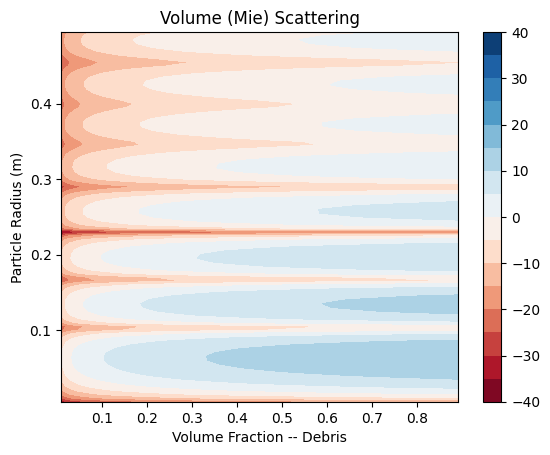

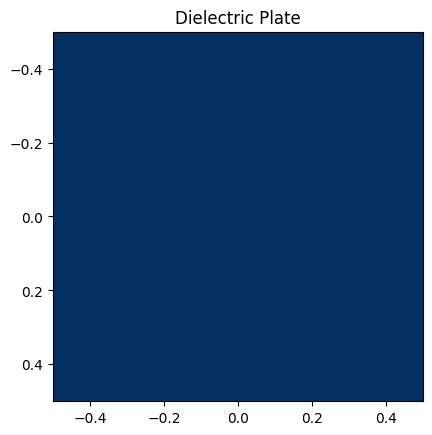

In [13]:
################################################################
### Generate the reflectivity image

depth=1000
R = fresnel_reflectivity_normal(3.16,3.18)
isochron = refl_to_dB(R*np.pi**3*(elevation+depth/np.sqrt(e_b))**2)
print(isochron)

R = fresnel_reflectivity_normal(3.16,6)
debris_layer = refl_to_dB(R*np.pi**3*(elevation+depth/np.sqrt(e_b))**2)
print(debris_layer-isochron)

cdata = plt.contourf(xgrid,ygrid,10*np.log10(k_back*np.pi*lambda_b*depth/2)-isochron,levels=np.arange(-40,41,5),cmap='RdBu',vmin=-40,vmax=40)
plt.colorbar(cdata)
plt.title('Volume (Mie) Scattering')
plt.xlabel('Volume Fraction -- Debris')
plt.ylabel('Particle Radius (m)')
if generate_pdfs_flag == 1:
    plt.savefig('Scattering.pdf')

plt.figure()
plt.title('Dielectric Plate')
plt.imshow(np.array([[debris_layer-isochron]]),cmap='RdBu',vmin=-40,vmax=40)

if generate_pdfs_flag == 1:
    plt.savefig('Scattering2.pdf')